# Koninklijke Bibliotheek

## Mining Delpher data with a Jupyter Notebook.


# Working with data from disk
https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip

This file was downloaded and unzipped in the directory 'data', let's explore.


In [1]:
import os # External library to interact with operating system

BASE_PATH = 'data'
tsv = BASE_PATH + os.sep
if os.path.isdir(BASE_PATH):    
    tsv += [f for f in os.listdir('data') if f.endswith('tsv')][0]
else:
    print("Please download & unpack data file: https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
tsv

stopwords = """
aan
aangaande
aangezien
achte
achter
achterna
af
afgelopen
al
aldaar
aldus
alhoewel
alias
alle
allebei
alleen
alles
als
alsnog
altijd
altoos
ander
andere
anders
anderszins
beetje
behalve
behoudens
beide
beiden
ben
beneden
bent
bepaald
betreffende
bij
bijna
bijv
binnen
binnenin
blijkbaar
blijken
boven
bovenal
bovendien
bovengenoemd
bovenstaand
bovenvermeld
buiten
bv
daar
daardoor
daarheen
daarin
daarna
daarnet
daarom
daarop
daaruit
daarvanlangs
dan
dat
de
deden
deed
der
derde
derhalve
dertig
deze
dhr
die
dikwijls
dit
doch
doe
doen
doet
door
doorgaand
drie
duizend
dus
echter
een
eens
eer
eerdat
eerder
eerlang
eerst
eerste
eigen
eigenlijk
elk
elke
en
enig
enige
enigszins
enkel
er
erdoor
erg
ergens
etc
etcetera
even
eveneens
evenwel
gauw
ge
gedurende
geen
gehad
gekund
geleden
gelijk
gemoeten
gemogen
genoeg
geweest
gewoon
gewoonweg
haar
haarzelf
had
hadden
hare
heb
hebben
hebt
hedden
heeft
heel
hem
hemzelf
hen
het
hetzelfde
hier
hierbeneden
hierboven
hierin
hierna
hierom
hij
hijzelf
hoe
hoewel
honderd
hun
hunne
ieder
iedere
iedereen
iemand
iets
ik
ikzelf
in
inderdaad
inmiddels
intussen
inzake
is
ja
je
jezelf
jij
jijzelf
jou
jouw
jouwe
juist
jullie
kan
klaar
kon
konden
krachtens
kun
kunnen
kunt
laatst
later
liever
lijken
lijkt
maak
maakt
maakte
maakten
maar
mag
maken
me
meer
meest
meestal
men
met
mevr
mezelf
mij
mijn
mijnent
mijner
mijzelf
minder
miss
misschien
missen
mits
mocht
mochten
moest
moesten
moet
moeten
mogen
mr
mrs
mw
na
naar
nadat
nam
namelijk
nee
neem
negen
nemen
nergens
net
niemand
niet
niets
niks
noch
nochtans
nog
nogal
nooit
nu
nv
of
ofschoon
om
omdat
omhoog
omlaag
omstreeks
omtrent
omver
ondanks
onder
ondertussen
ongeveer
ons
onszelf
onze
onzeker
ooit
ook
op
opnieuw
opzij
over
overal
overeind
overige
overigens
paar
pas
per
precies
recent
redelijk
reeds
rond
rondom
samen
sedert
sinds
sindsdien
slechts
sommige
spoedig
steeds
tamelijk
te
tegen
tegenover
tenzij
terwijl
thans
tien
tiende
tijdens
tja
toch
toe
toen
toenmaals
toenmalig
tot
totdat
tussen
twee
tweede
u
uit
uitgezonderd
uw
vaak
vaakwat
van
vanaf
vandaan
vanuit
vanwege
veel
veeleer
veertig
verder
verscheidene
verschillende
vervolgens
via
vier
vierde
vijf
vijfde
vijftig
vol
volgend
volgens
voor
vooraf
vooral
vooralsnog
voorbij
voordat
voordezen
voordien
voorheen
voorop
voorts
vooruit
vrij
vroeg
waar
waarom
waarschijnlijk
wanneer
want
waren
was
wat
we
wederom
weer
weg
wegens
weinig
wel
weldra
welk
welke
werd
werden
werder
wezen
whatever
wie
wiens
wier
wij
wijzelf
wil
wilden
willen
word
worden
wordt
zal
ze
zei
zeker
zelf
zelfde
zelfs
zes
zeven
zich
zichzelf
zij
zijn
zijne
zijzelf
zo
zoals
zodat
zodra
zonder
zou
zouden
zowat
zulk
zulke
zullen
zult
"""


In [3]:
df = pd.read_csv(tsv, sep='\t', names=["name","period", "zip_name", "path"])

# What period is coverd?

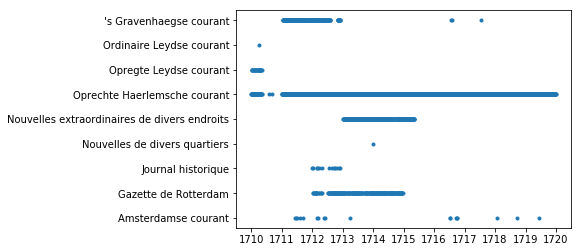

In [4]:
df.head(1)

df['period']= pd.to_datetime(df['period'], format='%Y-%m-%d')
df.set_index(df['period'],inplace=True)
plt.plot(df['period'], df['name'], '.')

In [5]:
list(df.name.unique())


['Amsterdamse courant',
 'Gazette de Rotterdam',
 'Journal historique',
 'Nouvelles de divers quartiers',
 'Nouvelles extraordinaires de divers endroits',
 'Oprechte Haerlemsche courant',
 'Opregte Leydse courant',
 'Ordinaire Leydse courant',
 "'s Gravenhaegse courant"]

In [6]:
#https://nl.wikipedia.org/wiki/V%C3%B6lkertafel
import xml.etree.ElementTree as ET  
from langdetect import detect
from pattern.nl import sentiment


mask = ((df['name'] == "'s Gravenhaegse courant") | 
        (df['name'] == "Amsterdamse courant") |
        (df['name'] == "Oprechte Haerlemsche courant") |
        (df['name'] == "Ordinaire Leydse courant")
       )
wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df[mask]["path"])]



#wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df["path"])]


article_strings = []

for path in wanted_paths:
    text_files = [path + os.sep + f for f in os.listdir(path) if f.endswith('_articletext.xml')]
    #article_count.append(len(text_files))
    for file_name in text_files:
        tree = ET.parse(file_name)
        for item in tree.iter():
            if item.text and item.text.strip():
                #if detect(item.text) == 'nl':
                article_strings.append(item.text)
#df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
#df.append(pd.DataFrame(article_count, lang_list, columns=['num_articles', 'lang_list']))

In [7]:
## Let's get some dirt :)

dirt = [a for a in article_strings if sentiment(a)[0] < -0.1]


word_list = {}
sentences = []
for article in dirt:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            #if not word.lower() in stopwords:
            if len(word) > 3 and not word in stopwords:
                sent.append(word)
    
    sentences.append(sent)
                
            
print([(w,word_list[w]) for w in word_list if word_list[w] > 11 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
neg = set([w for w in word_list if word_list[w] > 11 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])

[('Juny', 60), ('Minifter', 28), ('Genua', 17), ('Heden', 23), ('Lord', 32), ('Majt', 30), ('July', 48), ('Huys', 31), ('Minifters', 29), ('Nederlanden', 16), ('Hertog', 127), ('Secretaris', 29), ('Holland', 38), ('Envoyé', 16), ('Giaef', 30), ('Baron', 48), ('Heer', 168), ('Weenen', 27), ('Konings', 13), ('Karel', 15), ('Koning', 198), ('Leger', 59), ('Geallieerden', 27), ('Prins', 109), ('Sweedfe', 14), ('Saxen', 15), ('Augufty', 23), ('Heet', 36), ('Sondag', 17), ('Italien', 14), ('Woensdag', 26), ('Donderdag', 21), ('Hamburg', 28), ('Koningin', 71), ('Willem', 13), ('Frans', 16), ('Capiteyn', 12), ('Heeren', 81), ('Staten', 73), ('Stad', 207), ('Kerk', 17), ('Gedeputeerden', 50), ('Brieven', 49), ('January', 45), ('Turken', 14), ('Capt', 15), ('Schipper', 23), ('London', 19), ('Gravenhage', 26), ('Schepen', 89), ('Maendag', 21), ('Graef', 160), ('Marquis', 44), ('Generael', 85), ('Gouverneur', 36), ('Vlaenderen', 16), ('Regeering', 15), ('Engeland', 34), ('Raed', 65), ('Baton', 18)

In [8]:
## Let's get some positivity :)

dirt = [a for a in article_strings if sentiment(a)[0] > 0.1]

word_list = {}
sentences = []
for article in dirt:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            #if not word.lower() in stopwords:
            if len(word) > 3 and not word in stopwords:
                sent.append(word)
    
    sentences.append(sent)
                
            
print([(w,word_list[w]) for w in word_list if word_list[w] > 11 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
pos = set([w for w in word_list if word_list[w] > 11 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])

[('Bendei', 15), ('Koning', 2288), ('Turkfe', 31), ('Vorft', 583), ('Gcnerael', 209), ('Staniflaus', 76), ('Kiow', 62), ('Louis', 194), ('Amfterdam', 1904), ('Schepenen', 134), ('July', 1677), ('Gouda', 309), ('Lucas', 123), ('Keyfei', 103), ('Frans', 480), ('Heer', 7939), ('Amftetdam', 153), ('Jacobus', 156), ('Boekverkoper', 88), ('Boek', 21), ('Makelaer,', 187), ('Woensdag', 1486), ('Juny,', 155), ('Rotterdam', 1237), ('Hetberg', 13), ('Swarte', 252), ('Heere', 81), ('Alexander', 149), ('Vrouwe', 63), ('Koorn', 129), ('Huys', 3124), ('Land', 1075), ('Weyde', 38), ('Eyke', 46), ('Ovei', 15), ('Neder', 53), ('Giave', 26), ('Goederen', 1220), ('Conditien', 20), ('Kloek', 62), ('Zyde', 79), ('Winkel', 57), ('Lakenen', 32), ('Kroon', 220), ('Regenten', 431), ('Boedel', 223), ('Willem', 929), ('Reftor', 14), ('Edam', 33), ('Jeugt', 14), ('Hend', 58), ('Velfen,', 20), ('Nieuwe', 394), ('Lote', 13), ('Amft', 188), ('Diac', 274), ('Armen,', 55), ('Juoy,', 12), ('Weenen', 1249), ('Keyferinne'

In [14]:
sorted(neg - (pos - neg))

['Admirael',
 'Amfterdam',
 'April',
 'Armee',
 'Audiëntie',
 'Augufti',
 'Augufty',
 'Baden',
 'Bagage',
 'Bank',
 'Barcelona',
 'Baron',
 'Baton',
 'Bern',
 'Brief',
 'Brieven',
 'Canon',
 'Cantons',
 'Capiteyn',
 'Capt',
 'Commandant',
 'Commercie',
 'Compagnie',
 'Conferentie',
 'Congres',
 'Coning',
 'Convoy',
 'Corps',
 'Courier',
 'Czaar',
 'Czaer',
 'Daer',
 'December',
 'Deenfe',
 'Dewyl',
 'Diac',
 'Dingsdag',
 'Donderdag',
 'Engeland',
 'Engelfe',
 'Engels',
 'Envoyé',
 'Excellentie',
 'February',
 'Franffe',
 'Franfle',
 'Frans',
 'Geallieerden',
 'Gedeputeerde',
 'Gedeputeerden',
 'Geit',
 'Generael',
 'Genua',
 'Gezant',
 'Giaef',
 'Gifteren',
 'Goederen',
 'Gouverneur',
 'Gracf',
 'Graef',
 'Gravenhage',
 'Gtaef',
 'Hamburg',
 'Heden',
 'Heer',
 'Heeren',
 'Heet',
 'Heeten',
 'Heitog',
 'Hertog',
 'Hettog',
 'Holland',
 'Hollandfe',
 'Hollant',
 'Huys',
 'Italien',
 'Jacob',
 'James',
 'January',
 'John',
 'July',
 'Juny',
 'Kafteel',
 'Kapiteyn',
 'Kapt',
 'Karel',
 'Ke

In [15]:
sorted(pos - (neg - pos))

['A&icn',
 'A&ie',
 'A&ien',
 'ABRAH',
 'ABRAHAM',
 'AHAM',
 'Aaien',
 'Abbe',
 'Abcoude',
 'Abdis',
 'Abdy',
 'Abdye',
 'Abdyen',
 'Aberdeen',
 'Abrah',
 'Abraham',
 'Abrahams',
 'Abuyfen',
 'Academie',
 'Accijns',
 'Accommodement',
 'Accoort',
 'Achib',
 'Achtb',
 'Achtbare',
 'Achterftallen',
 'Achterom',
 'Achting',
 'Acquaviva',
 'Actiën',
 'Adam',
 'Adams',
 'Addifon',
 'Addres',
 'Adel',
 'Adel,',
 'Adelijcke',
 'Adherenten',
 'Adien',
 'Adies',
 'Adiiaen',
 'Adjutant',
 'Admi',
 'Admiiael',
 'Adminiftrateur',
 'Adminiftratie',
 'Admiracl',
 'Admirael',
 'Admiraliteit',
 'Admiraliteyt',
 'Admiraliteyten',
 'Admitael',
 'Admitaliteyt',
 'Adres',
 'Adres,',
 'Adriacn',
 'Adriaea',
 'Adriaen',
 'Adriaenfe',
 'Adrianopolen',
 'Adrianus',
 'Adrid',
 'Adtes',
 'Adtiaen',
 'Adtianopolen',
 'Advocaet',
 'Advocaten',
 'Advt',
 'Advyfen',
 'Advys',
 'Aelburg',
 'Aelft',
 'Aenfpraeck',
 'Aenfpraek',
 'Aenftaende',
 'Aengaende',
 'Aens',
 'Aerde',
 'Aeris',
 'Aernhem',
 'Aernout',
 'Aerts',